In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wandb  # Weights & Biases

from FNN import FNN
from ActivFunctions import relu, softmax_vec
from LossFunctions import SoftmaxCrossEntropy, SoftmaxCrossEntropyDerivative
from gradient_descent import (
    train_minibatch_sgd,
    train_minibatch_sgd_momentum,
    train_minibatch_rmsprop,
    train_minibatch_nag,
    train_minibatch_adam,
)

np.random.seed(42)

# HYPERPARAMETERS
hyperparams = {
    # Data
    "train_path": "Data/fashion-mnist_train.csv",
    "test_path":  "Data/fashion-mnist_test.csv",

    # Architecture
    "num_hidden_layers": 3,             # 2 x [512, 256] 3 x [512, 256, 128]
    "n_hidden_units": [256, 256, 256],   # one entry per hidden layer
    "activation_hidden": "relu",         # store as string for wandb config
    "activation_output": "softmax_vec",  # store as string for wandb config
    "weights_init": "HeNor",

    # Training / Optimization
    "epochs": 20,
    "learning_rate": 0.0005,
    "batch_size": 126,
    "optimizer": "adam",   # "sgd", "sgd_momentum", "nag", "rmsprop", "adam"

    # Optimizer-specific parameters
    "momentum": 0.9,       # for sgd_momentum / nag
    "rmsprop_beta": 0.9,   # for rmsprop
    "beta1": 0.9,          # for adam
    "beta2": 0.999,        # for adam
    "epsilon": 1e-8,       # for adam / rmsprop


    # Regularization
    "l1_coeff": 0.0,
    "l2_coeff": 0.0,

    # Misc
    "val_fraction": 0.1,   # fraction of train set used as validation
}

assert hyperparams["num_hidden_layers"] == len(hyperparams["n_hidden_units"]), \
    "num_hidden_layers must equal len(n_hidden_units)"

# Map string names to actual functions AFTER config (for code use)
ACTIVATION_FUNCS = {
    "relu": relu,
    # add more if needed
}
OUTPUT_ACTIVATION_FUNCS = {
    "softmax_vec": softmax_vec,
    # add more if needed
}

loss_fn = SoftmaxCrossEntropy
loss_deriv_fn = SoftmaxCrossEntropyDerivative

activation_hidden_fn = ACTIVATION_FUNCS[hyperparams["activation_hidden"]]
activation_output_fn = OUTPUT_ACTIVATION_FUNCS[hyperparams["activation_output"]]


In [2]:

# DATA LOADING + PREPROCESSING
def load_fashion_mnist(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)

    y_train = train_df["label"].to_numpy()
    X_train = train_df.drop(columns=["label"]).to_numpy().astype(np.float32)

    y_test = test_df["label"].to_numpy()
    X_test = test_df.drop(columns=["label"]).to_numpy().astype(np.float32)

    # normalize to [0, 1]
    X_train /= 255.0
    X_test  /= 255.0

    # to (features, samples)
    X_train = X_train.T
    X_test  = X_test.T

    return (X_train, y_train), (X_test, y_test)


def one_hot(y, num_classes=10):
    out = np.zeros((num_classes, y.shape[0]))
    out[y, np.arange(y.shape[0])] = 1
    return out


(X_train_full, y_train_full), (X_test, y_test) = load_fashion_mnist(
    hyperparams["train_path"],
    hyperparams["test_path"],
)

Y_train_full = one_hot(y_train_full, num_classes=10)
Y_test       = one_hot(y_test,       num_classes=10)

print("Full train:", X_train_full.shape, Y_train_full.shape)
print("Test      :", X_test.shape,      Y_test.shape)


# TRAIN / VALIDATION SPLIT

val_fraction = hyperparams["val_fraction"]

N = X_train_full.shape[1]
indices = np.random.permutation(N)

val_size = int(N * val_fraction)
val_idx = indices[:val_size]
train_idx = indices[val_size:]

X_train = X_train_full[:, train_idx]
Y_train = Y_train_full[:, train_idx]
y_train = y_train_full[train_idx]

X_val   = X_train_full[:, val_idx]
Y_val   = Y_train_full[:, val_idx]
y_val   = y_train_full[val_idx]

print("Train subset:", X_train.shape, Y_train.shape)
print("Val subset  :", X_val.shape,   Y_val.shape)


Full train: (784, 60000) (10, 60000)
Test      : (784, 10000) (10, 10000)
Train subset: (784, 54000) (10, 54000)
Val subset  : (784, 6000) (10, 6000)


In [3]:

# BUILD NETWORK FROM HYPERPARAMETERS
input_dim = X_train.shape[0]
num_classes = 10

layer_sizes = [input_dim] + hyperparams["n_hidden_units"] + [num_classes]

activations = [activation_hidden_fn] * hyperparams["num_hidden_layers"]
activations.append(activation_output_fn)

print("Architecture:", layer_sizes)

net = FNN(
    weights_info=layer_sizes,
    activ_functions_info=activations,
    method_ini=hyperparams["weights_init"],
)


Architecture: [784, 1024, 512, 256, 128, 10]


In [4]:

# LOSS + L2
def compute_loss_with_l2(network, X, Y, l2_coeff):
    """
    Total loss = SoftmaxCrossEntropy + L2 penalty (if l2_coeff > 0).
    Bias weights (last column of each W) are not regularized.
    """
    _, a_values = network.forward(X)
    logits = a_values[-1]

    data_loss = loss_fn(Y, logits)

    if l2_coeff != 0.0:
        l2 = 0.0
        for W in network.weights_list:
            W_no_bias = W[:, :-1]
            l2 += np.sum(W_no_bias ** 2)
        data_loss += 0.5 * l2_coeff * l2

    return data_loss


# OPTIMIZER DISPATCH
def train_network_once(net, X, Y, hp):
    """
    Train for hp['epochs'] epochs in one call using the selected optimizer.
    """
    opt = hp["optimizer"].lower()

    if opt == "sgd":
        return train_minibatch_sgd(
            network=net,
            inputs=X,
            targets=Y,
            epochs=hp["epochs"],
            learning_rate=hp["learning_rate"],
            batch_size=hp["batch_size"],
            loss_derivative=loss_deriv_fn,
            l1_coeff=hp["l1_coeff"],
            l2_coeff=hp["l2_coeff"],
        )

    if opt == "sgd_momentum":
        return train_minibatch_sgd_momentum(
            network=net,
            inputs=X,
            targets=Y,
            epochs=hp["epochs"],
            learning_rate=hp["learning_rate"],
            batch_size=hp["batch_size"],
            loss_derivative=loss_deriv_fn,
            momentum=hp["momentum"],
            l1_coeff=hp["l1_coeff"],
            l2_coeff=hp["l2_coeff"],
        )

    if opt == "nag":
        return train_minibatch_nag(
            network=net,
            inputs=X,
            targets=Y,
            epochs=hp["epochs"],
            learning_rate=hp["learning_rate"],
            batch_size=hp["batch_size"],
            loss_derivative=loss_deriv_fn,
            momentum=hp["momentum"],
            l1_coeff=hp["l1_coeff"],
            l2_coeff=hp["l2_coeff"],
        )

    if opt == "rmsprop":
        return train_minibatch_rmsprop(
            network=net,
            inputs=X,
            targets=Y,
            epochs=hp["epochs"],
            learning_rate=hp["learning_rate"],
            batch_size=hp["batch_size"],
            loss_derivative=loss_deriv_fn,
            beta=hp["rmsprop_beta"],
            l1_coeff=hp["l1_coeff"],
            l2_coeff=hp["l2_coeff"],
        )

    if opt == "adam":
        return train_minibatch_adam(
            network=net,
            inputs=X,
            targets=Y,
            epochs=hp["epochs"],
            learning_rate=hp["learning_rate"],
            batch_size=hp["batch_size"],
            loss_derivative=loss_deriv_fn,
            beta1=hp["beta1"],
            beta2=hp["beta2"],
            epsilon=hp["epsilon"],
            l1_coeff=hp["l1_coeff"],
            l2_coeff=hp["l2_coeff"],
        )

    raise ValueError(f"Unknown optimizer: {opt}")


# W&B TRAINING LOOP (TRAIN + VAL LOGGING)
def train_with_logs_wandb(net, X_train, Y_train, X_val, Y_val, hp):
    """
    Train for hp['epochs'] epochs, log train/val metrics to console and Weights & Biases.
    """
    # Initialize wandb run
    run = wandb.init(
        project="ffnn-from-scratch",
        config=hp,
        reinit=True,  # allows multiple runs in same notebook
    )

    # REMOVE / COMMENT OUT THIS LINE:
    # wandb.watch(net, log="all", log_freq=1)

    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    for epoch in range(hp["epochs"]):
        net = train_network_once(net, X_train, Y_train, {**hp, "epochs": 1})

        train_loss = compute_loss_with_l2(net, X_train, Y_train, hp["l2_coeff"])
        _, a_tr = net.forward(X_train)
        preds_tr = np.argmax(a_tr[-1], axis=0)
        labels_tr = np.argmax(Y_train, axis=0)
        train_acc = np.mean(preds_tr == labels_tr)

        val_loss = compute_loss_with_l2(net, X_val, Y_val, hp["l2_coeff"])
        _, a_val = net.forward(X_val)
        preds_val = np.argmax(a_val[-1], axis=0)
        labels_val = np.argmax(Y_val, axis=0)
        val_acc = np.mean(preds_val == labels_val)

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch+1}/{hp['epochs']} | "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
        )

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
        })

    run.finish()
    return net, history



# BASIC ACCURACY HELPER
def accuracy(network, X, Y):
    _, a_values = network.forward(X)
    preds = np.argmax(a_values[-1], axis=0)
    labels = np.argmax(Y, axis=0)
    return np.mean(preds == labels)


# CONFUSION MATRIX HELPERS
FASHION_MNIST_CLASSES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def compute_confusion_matrix(net, X, y_true_int, num_classes=10):
    _, a_values = net.forward(X)
    probs = a_values[-1]
    y_pred = np.argmax(probs, axis=0)

    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true_int, y_pred):
        cm[t, p] += 1
    return cm


def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix"):
    num_classes = cm.shape[0]
    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]

    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(
                j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


wandb: Currently logged in as: thludviksson17 (thludviksson17-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/20 | Train Loss: 0.3779 Acc: 0.8646 | Val Loss: 0.3883 Acc: 0.8625
Epoch 2/20 | Train Loss: 0.3273 Acc: 0.8788 | Val Loss: 0.3591 Acc: 0.8682
Epoch 3/20 | Train Loss: 0.3026 Acc: 0.8879 | Val Loss: 0.3401 Acc: 0.8813
Epoch 4/20 | Train Loss: 0.2652 Acc: 0.9010 | Val Loss: 0.3227 Acc: 0.8777
Epoch 5/20 | Train Loss: 0.2511 Acc: 0.9051 | Val Loss: 0.3166 Acc: 0.8820
Epoch 6/20 | Train Loss: 0.2415 Acc: 0.9108 | Val Loss: 0.3234 Acc: 0.8883
Epoch 7/20 | Train Loss: 0.1990 Acc: 0.9259 | Val Loss: 0.2931 Acc: 0.8970
Epoch 8/20 | Train Loss: 0.2144 Acc: 0.9219 | Val Loss: 0.3139 Acc: 0.8880
Epoch 9/20 | Train Loss: 0.2052 Acc: 0.9218 | Val Loss: 0.3199 Acc: 0.8892
Epoch 10/20 | Train Loss: 0.1930 Acc: 0.9268 | Val Loss: 0.3226 Acc: 0.8943
Epoch 11/20 | Train Loss: 0.1570 Acc: 0.9412 | Val Loss: 0.3074 Acc: 0.9003
Epoch 12/20 | Train Loss: 0.1545 Acc: 0.9398 | Val Loss: 0.3246 Acc: 0.8940
Epoch 13/20 | Train Loss: 0.1847 Acc: 0.9305 | Val Loss: 0.3485 Acc: 0.8898
Epoch 14/20 | Train L

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▃▄▄▄▆▅▅▆▇▇▆▇▇▇▇▇▇█
train_loss,█▇▆▅▅▄▃▄▃▃▂▂▃▂▂▂▂▁▂▁
val_acc,▁▂▄▄▅▆▇▆▆▇█▇▆▇█▇█▇▆█
val_loss,█▆▄▃▃▃▁▃▃▃▂▃▅▆▄▇▃▅▆▆
epoch,20
train_acc,0.95885
train_loss,0.11328
val_acc,0.89967
val_loss,0.36061


Training complete
Final Train loss: 0.1133 | Train acc: 0.9589
Final Val   loss: 0.3606 | Val   acc: 0.8997
Final Test  loss: 0.3439 | Test  acc: 0.9038


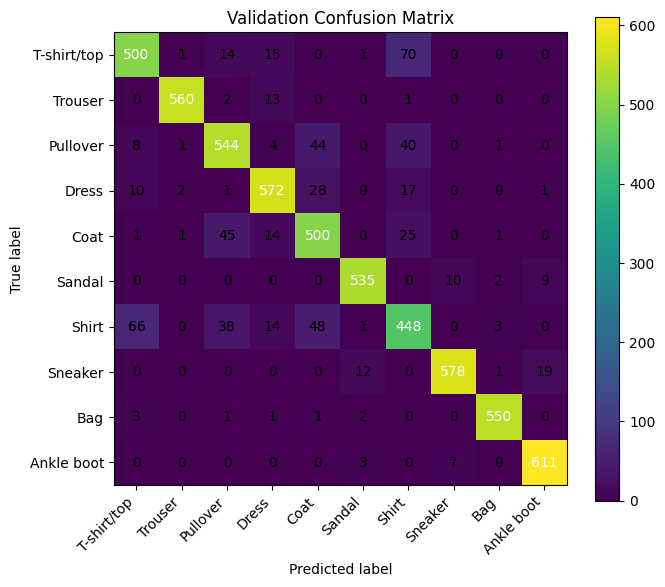

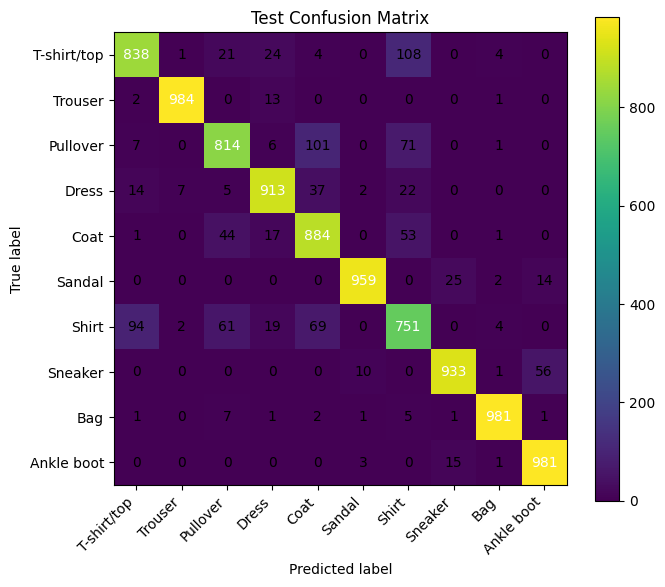

In [5]:

# TRAIN (WITH W&B LOGGING)
trained_net, history = train_with_logs_wandb(
    net, X_train, Y_train, X_val, Y_val, hyperparams
)
print("Training complete")

# FINAL EVAL

train_acc = accuracy(trained_net, X_train, Y_train)
val_acc   = accuracy(trained_net, X_val,   Y_val)
test_acc  = accuracy(trained_net, X_test,  Y_test)

train_loss = compute_loss_with_l2(trained_net, X_train, Y_train, hyperparams["l2_coeff"])
val_loss   = compute_loss_with_l2(trained_net, X_val,   Y_val,   hyperparams["l2_coeff"])
test_loss  = compute_loss_with_l2(trained_net, X_test,  Y_test,  hyperparams["l2_coeff"])

print(f"Final Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
print(f"Final Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.4f}")
print(f"Final Test  loss: {test_loss:.4f} | Test  acc: {test_acc:.4f}")

# CONFUSION MATRICES (VAL + TEST)
cm_val = compute_confusion_matrix(trained_net, X_val, y_val, num_classes=10)
plot_confusion_matrix(cm_val, FASHION_MNIST_CLASSES, title="Validation Confusion Matrix")

cm_test = compute_confusion_matrix(trained_net, X_test, y_test, num_classes=10)
plot_confusion_matrix(cm_test, FASHION_MNIST_CLASSES, title="Test Confusion Matrix")
